<a href="https://colab.research.google.com/github/tavaresRamon/AprendizadoMaquina-LSTM/blob/main/modeloLSTMParaFocosDeIncendioPantanal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as stats

In [3]:
# Carregando arquivos
uploadArquivos = files.upload()

Saving dadosProntos2.csv to dadosProntos2.csv


In [4]:
# Arquivando meus dados em uma lista
meusDados = list(uploadArquivos.keys())[0]
dados0 = pd.read_csv(meusDados)

In [5]:
dados0

,focos_incendio,data
0,12,1998-06-01
1,206,1998-07-01
2,172,1998-08-01
3,542,1998-09-01
4,507,1998-10-01
...,...,...
301,126,2023-07-01
302,110,2023-08-01
303,373,2023-09-01
304,1157,2023-10-01


In [6]:
dados = dados0

In [7]:
dados['data'] = pd.to_datetime(dados['data'])
#dados['media_diaria_focos'] = dados['media_diaria_focos'].astype(int)

In [8]:
dados

,focos_incendio,data
0,12,1998-06-01
1,206,1998-07-01
2,172,1998-08-01
3,542,1998-09-01
4,507,1998-10-01
...,...,...
301,126,2023-07-01
302,110,2023-08-01
303,373,2023-09-01
304,1157,2023-10-01


In [9]:
# Definindo as datas em índices
dados.set_index('data', inplace=True)


In [10]:
# Realizando a decomposição sazonal
frequencia = pd.infer_freq(dados.index)
decomposicaoSazonal = stats.tsa.seasonal_decompose(dados['focos_incendio'],model='additive',period=(12))
sazonalidade = decomposicaoSazonal.seasonal
residuos = decomposicaoSazonal.resid
tendencia = decomposicaoSazonal.trend

# Criando variáveis da decomposição sazonal
dados['sazonalidade'] = sazonalidade
dados['tendencia'] = tendencia
dados['residuos'] = residuos

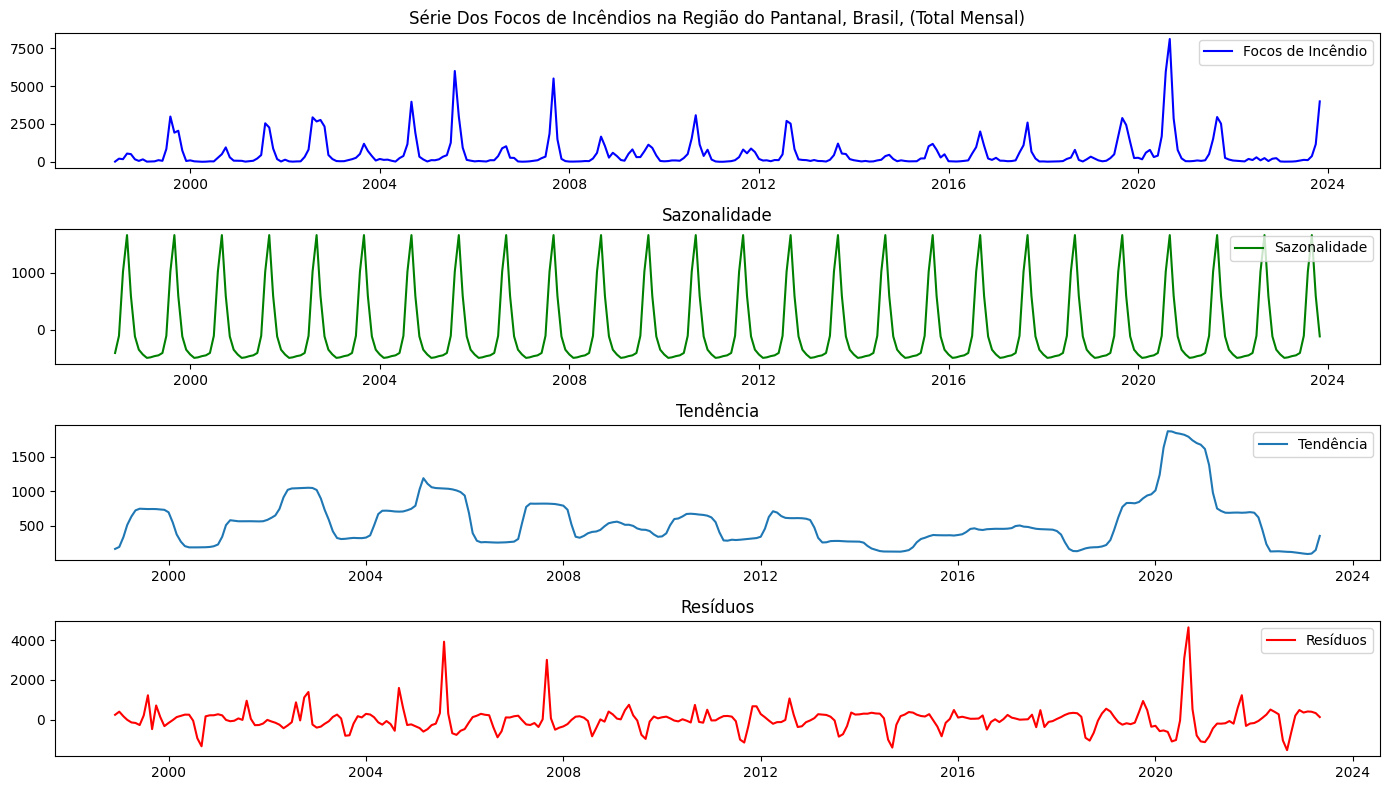

In [43]:
# Defina o tamanho dos gráficos
plt.figure(figsize=(14, 8))


# Gráfico 1: Série Temporal Original
plt.subplot(4, 1, 1)
plt.plot(dados['focos_incendio'], label='Focos de Incêndio', color="blue")
plt.title('Série Dos Focos de Incêndios na Região do Pantanal, Brasil, (Total Mensal)')
plt.legend()

# Gráfico 1: Série Temporal Original
plt.subplot(4, 1, 2)
plt.plot(sazonalidade, label='Sazonalidade', color="green")
plt.title('Sazonalidade')
plt.legend()

# Gráfico 2: Tendência
plt.subplot(4, 1, 3)
plt.plot(tendencia, label='Tendência')
plt.title('Tendência')
plt.legend()

# Gráfico 3: Resíduos
plt.subplot(4, 1, 4)
plt.plot(residuos, label='Resíduos',color="red")
plt.title('Resíduos')
plt.legend()

# Ajuste o espaçamento entre os gráficos
plt.tight_layout()
plt.show()


In [16]:
# Teste ADF Hipótese nula: Série não é estacionária
resultadoAdf = stats.tsa.adfuller(dados['focos_incendio'])
valorAdf = resultadoAdf[1]

if valorAdf < 0.05:
    print("A série é estacionária (hipótese nula rejeitada).")
else:
    print("A série não é estacionária (hipótese nula não rejeitada).")


A série é estacionária (hipótese nula rejeitada).


In [ ]:
#from sklearn.preprocessing import MinMaxScaler
#Normalização dos dados
#scaler = MinMaxScaler()
#dados['focos_incendio'] = scaler.fit_transform(dados['focos_incendio'].values.reshape(-1, 1))

In [20]:
# Preparando os dados para a LSTM
def prepareDados(dados, periodo):
  x, y = [], []
  for i in range(len(dados) - periodo):
    x.append(dados[i:i+periodo])
    y.append(dados[i+periodo])
  return np.array(x), np.array(y)
lags = 12
var = 1
x,y = prepareDados(dados['focos_incendio'],lags)

In [21]:
# Divisão dos dados em treino e teste
treino = int(0.7 * len(x))
teste = int(0.2 * len(x))

In [22]:
# Construção dos dados em treinamento, validação e teste
xTreino, yTreino = x[:treino], y[:treino]
xValidacao, yValidacao = x[treino:(treino+teste)], y[treino:(treino+teste)]
xTeste, yTeste = x[treino+teste:], y[treino+teste:]
xTreino.shape,yTreino.shape, xValidacao.shape,yValidacao.shape,xTeste.shape,yTeste.shape


((205, 12), (205,), (58, 12), (58,), (31, 12), (31,))

In [24]:
from keras.src.layers.rnn.lstm_v1 import LSTM
from keras.src.engine.input_layer import InputLayer
from keras.layers import *
from keras.models import Sequential
from keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint
from keras.metrics import RootMeanSquaredError
from keras.optimizers import RMSprop, Adam, SGD

# Criação do modelo
modelo = Sequential()
modelo.add(InputLayer((lags, var)))
modelo.add(LSTM(256))
modelo.add(Dropout(0.2))
modelo.add(Dense(256, activation='relu'))
modelo.add(Dropout(0.2))
modelo.add(Dense(1, activation='linear'))
modelo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 330241 (1.26 MB)
Trainable params: 330241 (1.26 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
checkPoint = ModelCheckpoint('modelo/', save_best_only=True)
modelo.compile(loss=MeanSquaredError(),
               optimizer=Adam(learning_rate=0.001),
               metrics=[RootMeanSquaredError()])

In [ ]:
from keras.src import callbacks
history = modelo.fit(xTreino, yTreino,
           validation_data=(xValidacao, yValidacao),
           epochs=350,callbacks=[checkPoint])

In [27]:
from keras.models import load_model
modelo = load_model('modelo/')

In [31]:
loss = history.history['loss']

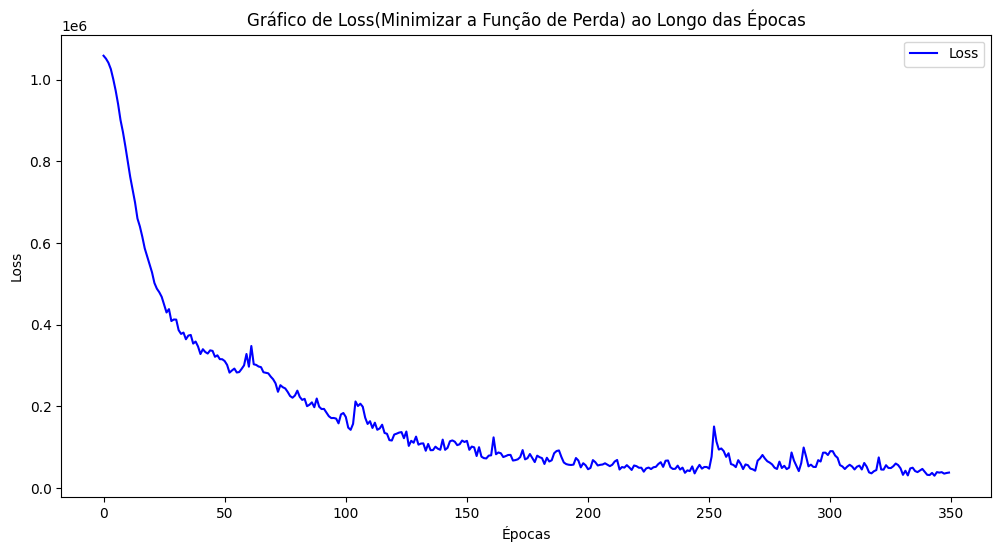

In [32]:
import matplotlib.pyplot as plt

# Supondo que 'history' seja o objeto retornado do treinamento do modelo
loss = history.history['loss']

# Criando o gráfico
plt.figure(figsize=(12, 6))
plt.plot(loss, label='Loss', color='blue')
plt.title('Gráfico de Loss(Minimizar a Função de Perda) ao Longo das Épocas')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()


In [33]:
from sklearn.metrics import mean_squared_error as mse
def plotarPredicoes(modelo, x, y):
  predicoes = modelo.predict(x).flatten()
  dados = pd.DataFrame(data={'Reais':y, 'Preditos':predicoes})
  plt.figure(figsize=(10, 4))
  plt.plot(dados['Reais'],label='Reais',color="blue")
  plt.plot(dados['Preditos'],label='Preditos',color="red")
  plt.title('Focos de Calor')
  plt.legend()
  plt.tight_layout()
  return dados, mse(y, predicoes)


In [34]:
predict = modelo.predict(xTreino).flatten()
dadosNovos = pd.DataFrame(data={
    'reais':yTreino,
    'preditos':predict
})
dadosNovos

7/7 [==============================] - 1s 20ms/step


,reais,preditos
0,65,226.615692
1,845,524.776245
2,2988,2875.840332
3,1922,2005.768799
4,2049,1995.217529
...,...,...
200,29,24.394562
201,18,30.391857
202,34,27.816628
203,59,80.276939


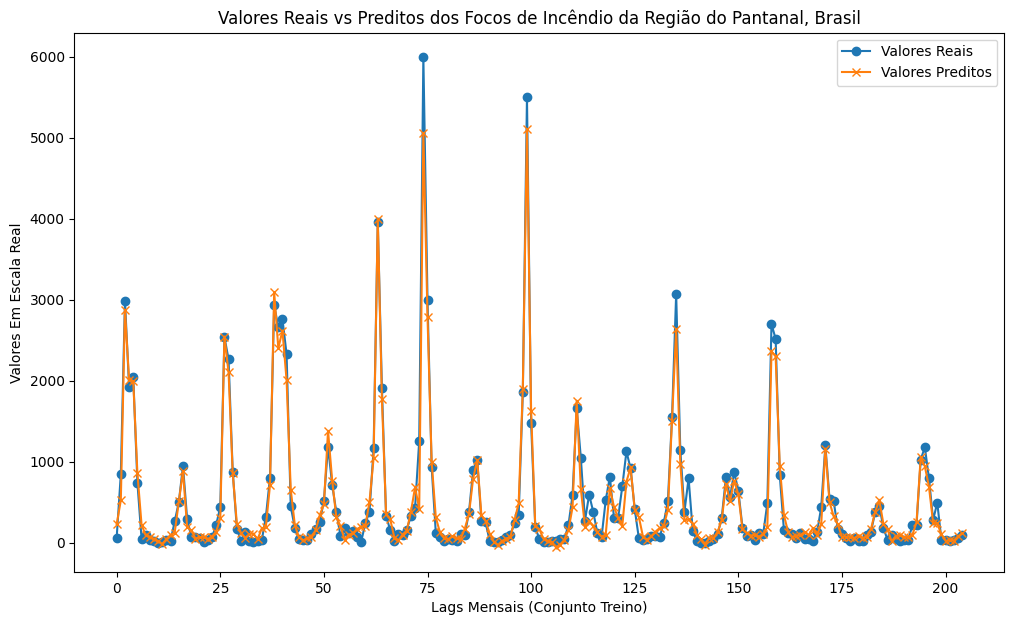

In [73]:
dadosNovos = pd.DataFrame(data={
    'reais': yTreino,
    'preditos': predict
})

# Criando o gráfico
plt.figure(figsize=(12, 7))
plt.plot(dadosNovos['reais'], label='Valores Reais', marker='o')
plt.plot(dadosNovos['preditos'], label='Valores Preditos', marker='x')
plt.title('Valores Reais vs Preditos dos Focos de Incêndio da Região do Pantanal, Brasil')
plt.xlabel('Lags Mensais (Conjunto Treino)')
plt.ylabel('Valores Em Escala Real')
plt.legend()
plt.grid(False)
plt.show()


In [67]:
predictValidacao = modelo.predict(xValidacao).flatten()
dadosNovosValidacao = pd.DataFrame(data={
    'reais': yValidacao,
    'preditos': predictValidacao
})

2/2 [==============================] - 0s 30ms/step


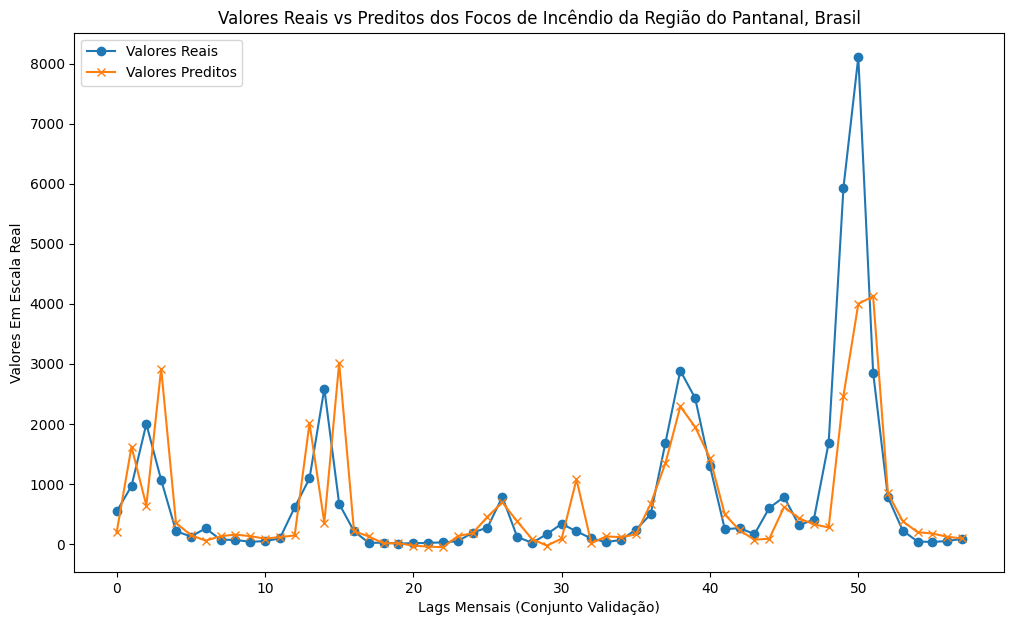

In [74]:
plt.figure(figsize=(12, 7))
plt.plot(dadosNovosValidacao['reais'], label='Valores Reais', marker='o')
plt.plot(dadosNovosValidacao['preditos'], label='Valores Preditos', marker='x')
plt.title('Valores Reais vs Preditos dos Focos de Incêndio da Região do Pantanal, Brasil')
plt.xlabel('Lags Mensais (Conjunto Validação)')
plt.ylabel('Valores Em Escala Real')
plt.legend()
plt.grid(False)
plt.show()


In [63]:
predictTeste = modelo.predict(xTeste).flatten()
dadosNovosTeste = pd.DataFrame(data={
    'reais': yTeste,
    'preditos': predictTeste
})

1/1 [==============================] - 0s 53ms/step


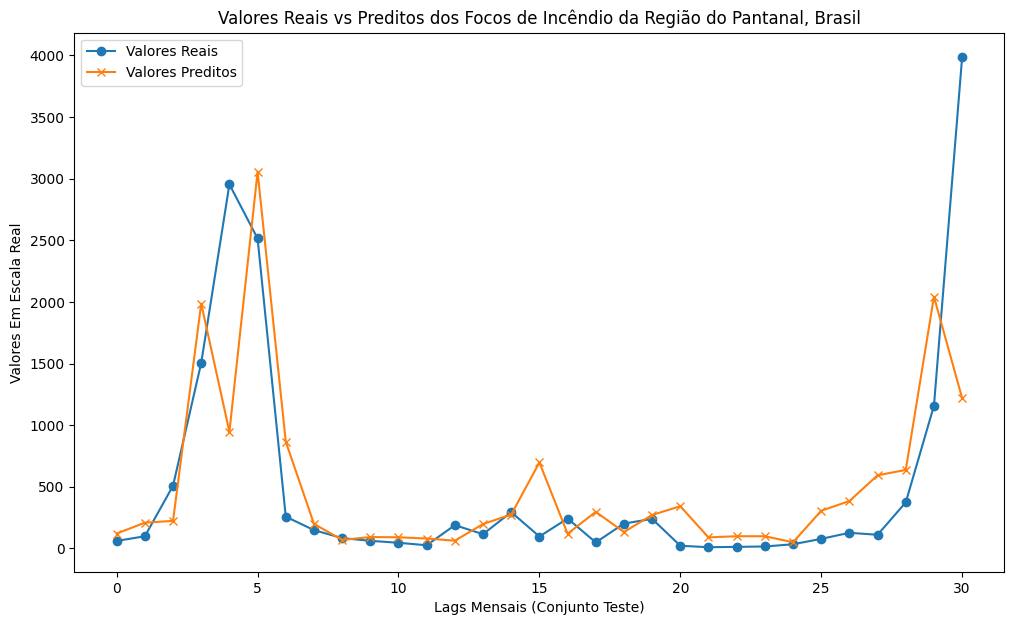

In [75]:
plt.figure(figsize=(12, 7))
plt.plot(dadosNovosTeste['reais'], label='Valores Reais', marker='o')
plt.plot(dadosNovosTeste['preditos'], label='Valores Preditos', marker='x')
plt.title('Valores Reais vs Preditos dos Focos de Incêndio da Região do Pantanal, Brasil')
plt.xlabel('Lags Mensais (Conjunto Teste)')
plt.ylabel('Valores Em Escala Real')
plt.legend()
plt.grid(False)
plt.show()